# Delayed Flights Decision Trees

In [34]:
# Initial imports
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,  accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import dtreeviz
import graphviz

In [35]:
# load data flight from amazon aws 
data = "https://airport-efficiency.s3.amazonaws.com/Merged_cleaned_airport_data.csv"
df = pd.read_csv(data)
df.head()

,YEAR,MONTH,DAY_OF_WEEK,BRANDED_CODE_SHARE,ORIGIN,DEST,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED,DATE,COVID,DELAY_REASON
0,2018,1,1,UA,BWI,DEN,Colorado,1608,1600.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
1,2018,1,1,UA,BWI,ORD,Illinois,1644,1637.0,-7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
2,2018,1,1,UA,BWI,IAH,Texas,1806,1800.0,-6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
3,2018,1,1,UA,BWI,IAH,Texas,828,828.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0
4,2018,1,1,UA,BWI,DEN,Colorado,810,802.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0


In [36]:
# merge "codeshares" to their corresponding airlines 
df.loc[(df.BRANDED_CODE_SHARE == "UA_CODESHARE"), "BRANDED_CODE_SHARE"] = "UA"
df.loc[(df.BRANDED_CODE_SHARE == "AA_CODESHARE"), "BRANDED_CODE_SHARE"] = "AA"
df.loc[(df.BRANDED_CODE_SHARE == "DL_CODESHARE"), "BRANDED_CODE_SHARE"] = "DL"
df.loc[(df.BRANDED_CODE_SHARE == "AS_CODESHARE"), "BRANDED_CODE_SHARE"] = "AS"


In [37]:
#divide the states into five regions 
northeast = ['Massachusetts',
'Rhode Island',
'Connecticut',
'Vermont',
'New Hampshire',
'Maine',
'Pennsylvania',
'New Jersey',
'New York'
]

souteast = ['Georgia',
'North Carolina',
'South Carolina',
'Virginia',
'West Virginia',
'Kentucky',
'Tennessee',
'Mississippi',
'Alabama',
'Delaware',
'Maryland',
'Florida',
'Louisiana',
'Arkansas'
]

midwest = ['Minnesota',
'Wisconsin',
'Illinois',
'Ohio',
'Indiana',
'Michigan',
'Missouri',
'Iowa',
'Kansas',
'Nebraska',
'North Dakota',
'South Dakota'
]

southwest = ['New Mexico',
'Arizona',
'Oklahoma',
'Texas'
]

west = ['California',
'Colorado',
'Nevada',
'Hawaii',
'Alaska',
'Oregon',
'Utah',
'Idaho',
'Montana',
'Wyoming',
'Washington'
]

noncontinental = ['U.S. Virgin Islands',
'Puerto Rico'
]

In [38]:
# this code created a new column "region" and classifies each state to its corresponding region 
regions=pd.DataFrame([northeast,souteast,midwest,southwest,west,noncontinental],index=['northeast','souteast','midwest','southwest','west','noncontinental'])
regions=regions.reset_index().melt('index')
df['Region'] = df['DEST_STATE_NM'].map(dict(zip(regions['value'],regions['index'])))

In [39]:
# drop more columns to make sure it does not overlap with delays. 
drop = ['DEP_TIME','DEP_DELAY_GROUP',  'DEST_STATE_NM', 'DEST', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'DELAY_REASON', 'CRS_DEP_TIME']
df_dropped = df.drop( drop , 1)

C:\Users\nizar\AppData\Local\Temp\ipykernel_3176\3290107065.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_dropped = df.drop( drop , 1)


In [40]:
# check the columns that are going to be used in our machine learning model 
df_dropped.columns.values.tolist()

['YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'BRANDED_CODE_SHARE',
 'ORIGIN',
 'DEP_TIME_BLK',
 'CANCELLED',
 'DIVERTED',
 'DELAYED',
 'DATE',
 'COVID',
 'Region']

# Encode Columns 
using get_dummies

In [58]:
brand_df = pd.get_dummies(df_dropped, columns=["BRANDED_CODE_SHARE"])
region_df = pd.get_dummies(brand_df, columns=["Region"])
final_df = pd.get_dummies(region_df, columns=["DEP_TIME_BLK"])


# Weather Data
only have data from 2019 and on

In [42]:
# load weatherflight from amazon aws 
weather_data = "https://airport-efficiency.s3.amazonaws.com/Combined+Weather+Data+2019-+March+2022.csv"
weather_df = pd.read_csv(weather_data)
weather_df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,...,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT09,WT09_ATTRIBUTES,WT11,WT11_ATTRIBUTES
0,USC00448084,"WEATHER FORECAST OFFICE STERLING, VA US",38.9764,-77.4869,87.8,2019-01-01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00448084,"WEATHER FORECAST OFFICE STERLING, VA US",38.9764,-77.4869,87.8,2019-01-02,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00448084,"WEATHER FORECAST OFFICE STERLING, VA US",38.9764,-77.4869,87.8,2019-01-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00448084,"WEATHER FORECAST OFFICE STERLING, VA US",38.9764,-77.4869,87.8,2019-01-04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00448084,"WEATHER FORECAST OFFICE STERLING, VA US",38.9764,-77.4869,87.8,2019-01-05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# create origin column using weather station ID 
weather_df.loc[(weather_df.STATION == 'USC00448084'), "ORIGIN"] = "IAD"
weather_df.loc[(weather_df.STATION == 'USW00093721'), "ORIGIN"] = "BWI"
weather_df.loc[(weather_df.STATION == 'USW00013743'), "ORIGIN"] = "DCA"


In [44]:
print(list(weather_df.columns))

['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'AWND_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES', 'WT09', 'WT09_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES', 'ORIGIN']


In [46]:
# columns used in analysis, average win, snowfall total, thunder, percipitation total, max and min temperature
weather_cleaned = weather_df[['DATE', 'ORIGIN', 'AWND', 'SNOW', 'WT03' , 'PRCP', 'TMAX', 'TMIN']]

In [47]:
weather_cleaned.head(-10)

,DATE,ORIGIN,AWND,SNOW,WT03,PRCP,TMAX,TMIN
0,2019-01-01,IAD,NaN,0.0,NaN,0.00,61.0,42.0
1,2019-01-02,IAD,NaN,0.0,NaN,0.00,45.0,37.0
2,2019-01-03,IAD,NaN,0.0,NaN,0.00,49.0,32.0
3,2019-01-04,IAD,NaN,0.0,NaN,0.04,46.0,28.0
4,2019-01-05,IAD,NaN,0.0,NaN,0.09,54.0,38.0
...,...,...,...,...,...,...,...,...
3543,2022-03-17,DCA,7.61,0.0,NaN,0.86,61.0,50.0
3544,2022-03-18,DCA,8.28,0.0,NaN,0.00,74.0,47.0
3545,2022-03-19,DCA,13.87,0.0,NaN,0.00,76.0,57.0
3546,2022-03-20,DCA,14.99,0.0,NaN,0.00,62.0,50.0


In [59]:
# keep flight data from 2019 onward
final_df2 = final_df[final_df['YEAR']>2018]

In [65]:
# merge dataframes on date and origin
merged_data= final_df2.merge(weather_cleaned, on=["DATE", 'ORIGIN'])

In [100]:
merged_data.head()

,YEAR,MONTH,DAY_OF_WEEK,ORIGIN,CANCELLED,DIVERTED,DELAYED,DATE,COVID,BRANDED_CODE_SHARE_AA,...,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,AWND,SNOW,WT03,PRCP,TMAX,TMIN
0,2019,1,7,BWI,0.0,0.0,0.0,2019-01-06,0.0,0,...,0,0,0,0,10.07,0.0,NaN,0.0,54.0,35.0
1,2019,1,7,BWI,0.0,0.0,0.0,2019-01-06,0.0,0,...,0,0,0,0,10.07,0.0,NaN,0.0,54.0,35.0
2,2019,1,7,BWI,0.0,0.0,0.0,2019-01-06,0.0,0,...,0,0,0,0,10.07,0.0,NaN,0.0,54.0,35.0
3,2019,1,7,BWI,0.0,0.0,0.0,2019-01-06,0.0,0,...,0,0,0,0,10.07,0.0,NaN,0.0,54.0,35.0
4,2019,1,7,BWI,0.0,0.0,0.0,2019-01-06,0.0,0,...,0,0,0,0,10.07,0.0,NaN,0.0,54.0,35.0


# Encode PT 2

In [101]:
# finish encoding 
origin_df = pd.get_dummies(merged_data, columns=["ORIGIN"])
origin_df['DATE'] = pd.to_datetime(origin_df['DATE'], format='%Y-%m-%d')
origin_df['DAY_OF_MONTH'] = origin_df.DATE.dt.day
merged_df = origin_df.drop('DATE', 1)

C:\Users\nizar\AppData\Local\Temp\ipykernel_3176\259386006.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged_df = origin_df.drop('DATE', 1)


In [102]:
# fill NANs with 0
merged_df =  merged_df.fillna(0)

In [103]:
merged_df.isna().sum()

YEAR                      0
MONTH                     0
DAY_OF_WEEK               0
CANCELLED                 0
DIVERTED                  0
DELAYED                   0
COVID                     0
BRANDED_CODE_SHARE_AA     0
BRANDED_CODE_SHARE_AS     0
BRANDED_CODE_SHARE_B6     0
BRANDED_CODE_SHARE_DL     0
BRANDED_CODE_SHARE_F9     0
BRANDED_CODE_SHARE_G4     0
BRANDED_CODE_SHARE_NK     0
BRANDED_CODE_SHARE_UA     0
BRANDED_CODE_SHARE_VX     0
BRANDED_CODE_SHARE_WN     0
Region_midwest            0
Region_noncontinental     0
Region_northeast          0
Region_souteast           0
Region_southwest          0
Region_west               0
DEP_TIME_BLK_0001-0559    0
DEP_TIME_BLK_0600-0659    0
DEP_TIME_BLK_0700-0759    0
DEP_TIME_BLK_0800-0859    0
DEP_TIME_BLK_0900-0959    0
DEP_TIME_BLK_1000-1059    0
DEP_TIME_BLK_1100-1159    0
DEP_TIME_BLK_1200-1259    0
DEP_TIME_BLK_1300-1359    0
DEP_TIME_BLK_1400-1459    0
DEP_TIME_BLK_1500-1559    0
DEP_TIME_BLK_1600-1659    0
DEP_TIME_BLK_1700-17

## Loading and Preprocessing Loans Encoded Data

In [104]:
# Define features set
X = merged_df.drop(columns=["DELAYED"])
X.head()

,YEAR,MONTH,DAY_OF_WEEK,CANCELLED,DIVERTED,COVID,BRANDED_CODE_SHARE_AA,BRANDED_CODE_SHARE_AS,BRANDED_CODE_SHARE_B6,BRANDED_CODE_SHARE_DL,...,AWND,SNOW,WT03,PRCP,TMAX,TMIN,ORIGIN_BWI,ORIGIN_DCA,ORIGIN_IAD,DAY_OF_MONTH
0,2019,1,7,0.0,0.0,0.0,0,0,0,1,...,10.07,0.0,0.0,0.0,54.0,35.0,1,0,0,6
1,2019,1,7,0.0,0.0,0.0,0,0,0,1,...,10.07,0.0,0.0,0.0,54.0,35.0,1,0,0,6
2,2019,1,7,0.0,0.0,0.0,0,0,0,1,...,10.07,0.0,0.0,0.0,54.0,35.0,1,0,0,6
3,2019,1,7,0.0,0.0,0.0,0,0,0,1,...,10.07,0.0,0.0,0.0,54.0,35.0,1,0,0,6
4,2019,1,7,0.0,0.0,0.0,0,0,0,1,...,10.07,0.0,0.0,0.0,54.0,35.0,1,0,0,6


 # Separate the features (X) from the target (y) 

In [105]:
# Define target vector
y = merged_df["DELAYED"]
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DELAYED, dtype: float64

 # Split our data into training and testing

In [106]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [107]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614648, 51)
(204883, 51)
(614648,)
(204883,)


# Feature Scaling

In [108]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Decision Tree Model

In [109]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(random_state =11)

In [110]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

## Making Predictions Using the Tree Model

In [111]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

## Model Evaluation

In [94]:
y_test.value_counts()

0.0    169427
1.0     35456
Name: DELAYED, dtype: int64

In [95]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[1, 0])
cm_df = pd.DataFrame(
    cm, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [96]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),10021,25435
Actual On-Time (0),14181,155246


Accuracy Score : 0.8066408633219935
Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89    169427
         1.0       0.41      0.28      0.34     35456

    accuracy                           0.81    204883
   macro avg       0.64      0.60      0.61    204883
weighted avg       0.78      0.81      0.79    204883



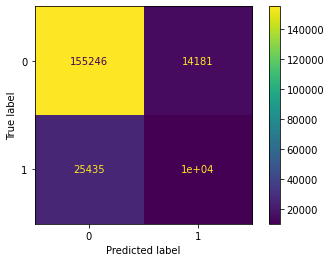

In [97]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions, labels=[0, 1]))
cm.plot()
plt.show()

Feature: 0, Score: 0.03860
Feature: 1, Score: 0.04353
Feature: 2, Score: 0.04891
Feature: 3, Score: 0.00185
Feature: 4, Score: 0.00361
Feature: 5, Score: 0.00415
Feature: 6, Score: 0.01991
Feature: 7, Score: 0.00456
Feature: 8, Score: 0.00830
Feature: 9, Score: 0.01218
Feature: 10, Score: 0.00350
Feature: 11, Score: 0.00167
Feature: 12, Score: 0.00608
Feature: 13, Score: 0.01688
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.01216
Feature: 16, Score: 0.03629
Feature: 17, Score: 0.00433
Feature: 18, Score: 0.03536
Feature: 19, Score: 0.04198
Feature: 20, Score: 0.02631
Feature: 21, Score: 0.02212
Feature: 22, Score: 0.00212
Feature: 23, Score: 0.01669
Feature: 24, Score: 0.01019
Feature: 25, Score: 0.01353
Feature: 26, Score: 0.01163
Feature: 27, Score: 0.01317
Feature: 28, Score: 0.01281
Feature: 29, Score: 0.01376
Feature: 30, Score: 0.01393
Feature: 31, Score: 0.01153
Feature: 32, Score: 0.01429
Feature: 33, Score: 0.01346
Feature: 34, Score: 0.01762
Feature: 35, Score: 0.01568
Fe

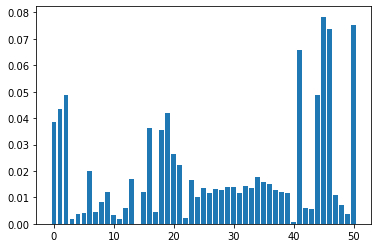

In [98]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [99]:
# We can sort the features by their importance.
columns = list(X)
importance_df = pd.DataFrame({'Feature': columns, 'Importance' : importance})
importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
45,TMAX,0.078368
50,DAY_OF_MONTH,0.075154
46,TMIN,0.073737
41,AWND,0.065773
2,DAY_OF_WEEK,0.048909
44,PRCP,0.048798
1,MONTH,0.043535
19,Region_souteast,0.041976
0,YEAR,0.038599
16,Region_midwest,0.036290
